In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print('Current cuda device: ',torch.cuda.get_device_name(0))

In [2]:
# Codes for the forward tomography problem
class tomography(nn.Module):

    def __init__(self, zs, ze, x, z):
      # rays start at (x[0], zs[i]) and end at (x[-1], ze[j])

        super().__init__()

        self.zs = zs
        self.ze = ze
        self.z  = z
        self.x  = x
        self.A = self.get_tomo_matrix(zs, ze, x, z)


    def get_ray(self, zs, ze, x, z):

        n = x.numel()
        X, Z = torch.meshgrid(x, z)


        s = (ze-zs)/(x[-1]-x[0])
        p = s*x + zs

        # Approximate the delta function over the path
        sigma = (x[1]-x[0])*2
        ray = torch.exp(-(X-x.unsqueeze(1))**2/sigma -(Z-p.unsqueeze(1))**2/sigma)
        ray[ray<0.1] = 0
        return ray

    def get_tomo_matrix(self, zs, ze, x, z):

        n = zs.numel()

        A = torch.zeros(0, x.numel()*z.numel())
        A = A.to_sparse()
        nrays = tqdm.trange(n)

        for i in nrays:
            ray = self.get_ray(zs[i], ze[i], x, z)
            ray = ray.reshape(1, -1)
            ray = ray.to_sparse()
            A = torch.cat((A,ray),dim=0)
            nrays.set_description('Percent computed: {:2f}'.format(100*i/n))

        return A.to(device)

    def forward(self, u):
      return self.A@u.flatten().to(device)

    def adjoint(self, b):
      return self.A.t()@b.flatten().to(device)


In [3]:
utrue = np.ones([64, 128])
for i in range(64):
  if i<42 and i>22:
    for j in range(128):
      if j>54 and j<74:
        utrue[i,j] = 5
u = torch.tensor(utrue, dtype=torch.float32).to(device)
utrue = u.clone().to(device)

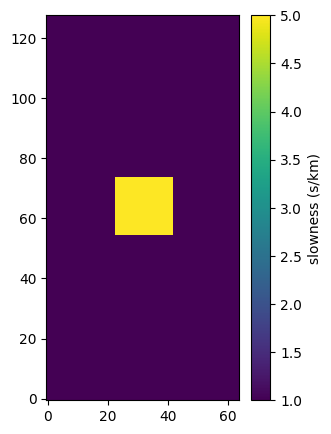

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(utrue.detach().cpu().reshape(64, 128).t(), origin = 'lower')
plt.axis('image')
plt.colorbar(label = 'slowness (s/km)')

We can now use the forward model and the simulated model to generate some data we can try to invert

In [5]:
x = torch.linspace(0, 63, 64)
z = torch.linspace(0, 127, 128)

t = torch.linspace(0, 127, 65)
zs, ze = torch.meshgrid(t, t)
zs = zs.flatten()
ze = ze.flatten()

tomo = tomography(zs, ze, x, z).to(device)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Percent computed: 99.976331: 100%|██████████| 4225/4225 [00:27<00:00, 154.86it/s]


In [6]:
d = tomo(u).to(device)
# Add noise to the data
torch.manual_seed(0)
noise = torch.randn_like(d)
sig   = 20
dn = (d + sig*noise).to(device)

SNR = (dn-d).norm()/dn.norm()
print('Noise level = ', (SNR).item())

Noise level =  0.09298304468393326


Here is the MLP for the case where a basic positional encoding is employed.

In [7]:
class NFTOMO(nn.Module):
    def __init__(self):
         super(NFTOMO, self).__init__()
         self.b1 = nn.Sequential(nn.Linear(4,128), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b2 = nn.Sequential(nn.Linear(128,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b3 = nn.Sequential(nn.Linear(256,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b4 = nn.Sequential(nn.Linear(256,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b5 = nn.Sequential(nn.Linear(256,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b6 = nn.Sequential(nn.Linear(256,128), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b7 = nn.Sequential(nn.Linear(128,1), nn.Tanh())

    def forward(self, x):
        x1 = self.b1(x)

        x2 = self.b2(x1)

        x3 = self.b3(x2)

        x4 = self.b4(x3)

        x5 = self.b5(x4)

        x6 = self.b6(x5)

        x7 = self.b7(x6)


        return torch.mul(x7,10)

In [8]:
torch.manual_seed(0)
np.random.seed(0)
_model = NFTOMO().to(device)


In [9]:
x1 = np.linspace(0,1,64)
x2 = np.linspace(0,1,128)
input_list = []
for i in x1:
  for k in x2:
    input_list.append([i,k])
input_ = torch.tensor(input_list, dtype=torch.float32).to(device)

In [10]:
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    # x_proj = (np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [11]:
t_pos_=input_mapping(input_.detach().cpu(), np.eye(2))
input_pos=torch.tensor(t_pos_, dtype=torch.float32).to(device)

In [12]:
# output = _model(input_)
output = _model(input_pos)

Text(0.5, 1.0, 'inital NF output')

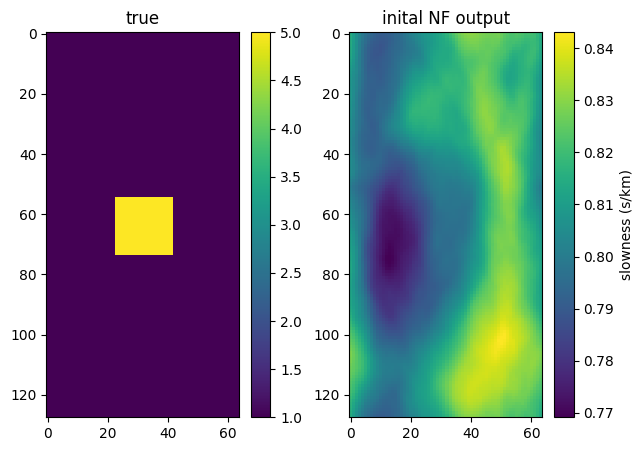

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(utrue.detach().cpu().reshape(64, 128).t())
plt.axis('image')
plt.colorbar()
plt.title('true')
plt.subplot(1,4,2)
plt.imshow(output.detach().cpu().reshape(64, 128).t())
plt.axis('image')
plt.colorbar(label = 'slowness (s/km)')
plt.title('inital NF output')

In [16]:
total_params = sum(p.numel() for p in _model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 264065


In [17]:
import torch.optim as optim
lr_ = 1e-3
optimizer = optim.Adam(_model.parameters(), lr=lr_)

In [18]:
def total_loss(output, Jtvec):
      """
          Note beta here differs from the beta in the convential EM inversion where beta typically starts with a value greater than 1 (e.x. 10), and then cooling down with a fixed rate.
          beta: [0,1]
          total_loss = (1-beta)*theta_phi + beta*theta_m
      """
      return (1/(output.size(dim=0)))*(Jtvec.t()@output)

In [19]:
%matplotlib inline
from IPython import display

In [20]:
import pickle

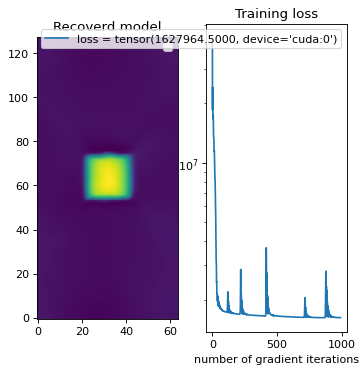

In [21]:
fig = plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)
losses = []

for epoch in range(1000):
    output = _model(input_pos)
    out_ = tomo.A@(output.detach())
    Jtvec = 2*tomo.A.t()@(out_-dn.unsqueeze(-1))
    loss = total_loss(output, Jtvec)
    optimizer.zero_grad()
    loss.backward()
    diff_ = ((out_-dn.unsqueeze(-1)).norm())**2
    losses.append(diff_.item())
    optimizer.step()
    if epoch%10 == 0:
      for ax in axes:
        ax.cla()
      axes[0].imshow(output.detach().cpu().reshape(64, 128).t(), origin = 'lower')
      axes[0].legend()
      axes[0].set_title('Recoverd model')
      axes[1].plot(losses, label='loss = ' + str(diff_))
      axes[1].set_yscale('log')
      axes[1].set_title('Training loss')
      axes[1].set_xlabel('number of gradient iterations')
      axes[1].legend()
      # print("The residual in the ", epoch, "is", ((out_-dn.unsqueeze(-1)).norm())**2)
      display.clear_output(wait=True)
      display.display(plt.gcf())
    if epoch%500 == 0:
      pkl_ = '7_layers_256_RELU_basic_pos'+'_'+str(epoch)
      pkl_name = pkl_+'.pkl'
      f = open(pkl_name, 'wb')
      pickle.dump(output, f)
      f.close()
plt.close('all')

In [22]:
import pickle
pkl_name = '7_layers_256_RELU_basic_pos_block'+'.pkl'
f = open(pkl_name, 'wb')
pickle.dump(output, f)
f.close()

In [23]:
torch.save(_model, '7_layers_256_RELU_basic_encording_block.pt')